# Building the 1D CNN

### Import the relevant packages

In [5]:
%matplotlib inline
import context
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import subprocess
import sys
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import (Add, Concatenate, Input, Dense, 
                                            Dropout, Embedding, Conv1D, 
                                            MaxPooling1D, GlobalAveragePooling1D, 
                                            Flatten)
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = os.getcwd()[:os.getcwd().rfind('Express')] + 'ExpressYeaself/'
SAVE_DIR = ROOT_DIR + 'expressyeaself/models/1d_cnn/saved_models/'

build = context.build_promoter
construct = context.construct_neural_net
encode = context.encode_sequences
organize = context.organize_data

#### Define filename of input data

In [6]:
sample_filename = ('10000_from_20190612130111781831_percentiles_els_binarized_homogeneous_deflanked_'
                   'sequences_with_exp_levels.txt.gz')

#### Define the absolute path of this file

In [7]:
sample_path = ROOT_DIR + 'example/processed_data/' + sample_filename

### Encode sequences

In [8]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, 
                                                                     method='One-Hot', 
                                                                     scale_els=True, 
                                                                     model_type='1DCNN', 
                                                                     binarized_els=True)
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)

### Reshape expression level array

In [10]:
y_scaled = y_scaled.reshape((len(y_scaled), 1))

### Perform a train-test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=0.3)

## Build the model architectures

### Sequential Model

In [16]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
kernel_size = 3
strides = 1
epochs = 20
dropout = 0.5

# Define the checkpointer to allow saving of models
model_type = '1d_cnn_sequential_onehot'
save_path = SAVE_DIR + model_type + '.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=save_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the model
model = Sequential()

# Build up the layers
model.add(Conv1D(filters, kernel_size, activation='relu', 
                 input_shape=(max_sequence_len, 5), 
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(3, strides))
# keras.layers.Flatten(data_format=None)
# model.add(GlobalAveragePooling1D())
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalAveragePooling1D())

# Add some dense and dropout layers
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 78, 15)            240       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 76, 15)            690       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 15)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 72, 15)            690       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 70, 15)            690       
_________________________________________________________________
global_average_pooling1d (Gl (None, 15)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0

### Parallel Model

In [12]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
# kernel_size
strides = 1
epochs = 20
dropout = 0.1
num_layers = 10

# Define the checkpointer to allow saving of models
model_type = '1d_cnn_parallel_onehot'
save_path = SAVE_DIR + model_type + '.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=save_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the inputs
inputs = Input(shape=(max_sequence_len, 5))
layers = []

# Build up the layers
for i in range(1, num_layers + 1):
    layer = Conv1D(filters, (2 * i - 1), strides)(inputs)
    layers.append(layer)

# Combine the layers
combined = Concatenate(axis=1)(layers)

# Add some flatten, dense, and dropout layers
out = Flatten()(combined)
# out = Dropout(dropout)(out)
out = Dense(500, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation='sigmoid')(out)
out = Dropout(dropout)(out)

# Define the model with inputs and outputs, and compile.
model = Model(inputs=inputs, outputs=out)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 5)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 80, 15)       90          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 78, 15)       240         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 76, 15)       390         input_1[0][0]                    
______________________________________________________________________________________________

### Binary Classifier Model

(Has same parallel layer architecture as the _Parallel Model_.)

In [17]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
# kernel_size
strides = 1
epochs = 20
dropout = 0.1
num_layers = 10

# Define the checkpointer to allow saving of models
model_type = '1d_cnn_classifier_onehot'
save_path = SAVE_DIR + model_type + '.hdf5'
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=save_path, 
                               verbose=1, 
                               save_best_only=True)

# Define the inputs
inputs = Input(shape=(max_sequence_len, 5))
layers = []

# Build up the layers
for i in range(2, num_layers + 1):
    kernel_size = (2 * i - 1)
#     strides = kernel_size
    layer = Conv1D(filters, kernel_size, strides)(inputs)
    layers.append(layer)

# Combine the layers
combined = Concatenate(axis=1)(layers)

# Add some flatten, dense, and dropout layers
out = Flatten()(combined)
out = Dropout(dropout)(out)
out = Dense(500, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation='sigmoid')(out)
# out = Dropout(dropout)(out)

# Define the model with inputs and outputs, and compile.
model = Model(inputs=inputs, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())

W0614 18:09:57.824165 4550550976 deprecation.py:323] From /Users/joe.abbott/miniconda3/envs/yeast/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 5)]      0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 78, 15)       240         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 76, 15)       390         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 74, 15)       540         input_2[0][0]                    
____________________________________________________________________________________________

### Fit and Evaluate the model

Train on 7000 samples, validate on 3000 samples
Epoch 1/20
6900/7000 [============================>.] - ETA: 0s - loss: 0.2766 - acc: 0.6467
Epoch 00001: val_acc improved from -inf to 0.72700, saving model to /Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/expressyeaself/models/1d_cnn/saved_models/1d_cnn_parallel_onehot.hdf5
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.2759 - acc: 0.6474 - val_loss: 0.1850 - val_acc: 0.7270
Epoch 2/20
6900/7000 [============================>.] - ETA: 0s - loss: 0.2148 - acc: 0.7043
Epoch 00002: val_acc improved from 0.72700 to 0.73167, saving model to /Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/expressyeaself/models/1d_cnn/saved_models/1d_cnn_parallel_onehot.hdf5
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.2149 - acc: 0.7043 - val_loss: 0.1816 - val_acc: 0.7317
Epoch 3/20
6900/7000 [============================>.] - ETA: 0s - loss: 0.2050 - acc: 0.7239
Epoch 00003: val

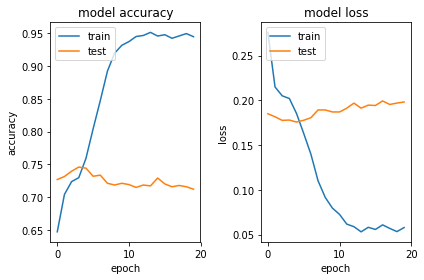

In [13]:
# Fit
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpointer])


# Evaluate
score = max(history.history['val_acc'])
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()

## Checking predictions on a small sample of native data

In [14]:
input_seqs = ROOT_DIR + 'expressyeaself/models/1d_cnn/native_sample.txt'
model_to_use = '1d_cnn_sequential'

In [15]:
construct.get_predictions_for_input_file(input_seqs, model_to_use, sort_df=True, write_to_file=False)

W0614 18:09:09.709701 4550550976 deprecation.py:506] From /Users/joe.abbott/miniconda3/envs/yeast/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0614 18:09:09.711513 4550550976 deprecation.py:506] From /Users/joe.abbott/miniconda3/envs/yeast/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/expressyeaself/construct_neural_net.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,index,seq,el_prediction
0,87,AGTGCGGGGGTCTAGGTCTCAGGTTAACTAGTGGATGCGGATGCTG...,0.975779
1,16,AGTACTCTTGCTCCCACACGCTCGCGCCTGGTACGTCTAAGGACGG...,0.940327
2,95,AGTGGAATTGTACGGGGCACATCTTAGGCAGGGGTGGATGCGGCTT...,0.856257
3,33,AGTATGTCGTCGCGTGTTGTTTCTAATCTTCGTGGCCTGTGGTGCA...,0.834777
4,22,AGTAGTGTGTACGCAGAACCCGGGCATGATCCTGCGCGACAACTTT...,0.779282
5,40,AGTCACTGGCCATTAGCGACGAAGTCTGTTGTCGTGGGTGCGAAGC...,0.778203
6,20,AGTAGCGGCGAAAGAGTCGTGGGTGCGCAGGTCTGCTCGCTTGGGG...,0.776115
7,96,AGTGGCATGTTGTGCTGTGTCGGGTCAGACAGGCATGGTGGTCAGG...,0.766534
8,1,AAAAGCGTAAGTTGCCCCCACGTTTTTCAGCGCTGCTGCGGAAGCG...,0.746711
9,58,AGTCGCTCGGAACGTTACAGTTCCGGGGTACAAGACGGGTTATTCT...,0.729927
